In [4]:
# Install necessary libraries
!pip install tensorflow matplotlib scikit-learn

In [5]:
# Import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import scikit-learn tools for data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Import TensorFlow tools for image preprocessing and model building
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from google.colab import drive, files

In [7]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Dataset paths
train_dir = "/content/deepfake/Train"
test_dir = "/content/deepfake/Test"

# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [11]:
# Load and preprocess dataset
def load_data(folder):
    data = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)) and not d.startswith('.')])
    label_map = {name: i for i, name in enumerate(class_names)}

    for label in class_names:
        class_path = os.path.join(folder, label)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=IMG_SIZE)
                    img_array = img_to_array(img) / 255.0
                    data.append(img_array)
                    labels.append(label_map[label])
                except Exception as e:
                    print(f"❌ Error loading {img_path}: {e}")

    return np.array(data), np.array(labels), class_names

X_train, y_train, class_labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
# Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"📌 Classes: {class_labels}")


✅ Train: (431, 128, 128, 3), Val: (48, 128, 128, 3), Test: (499, 128, 128, 3)
📌 Classes: ['fake', 'real']


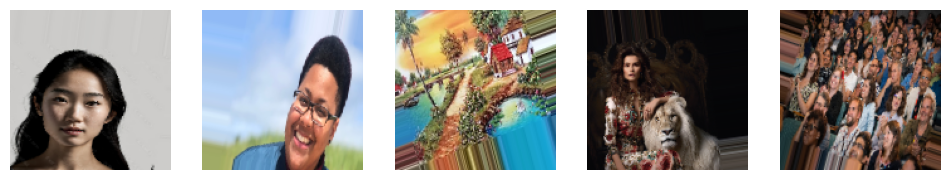

In [13]:
# Data Augmentation Preview
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

aug_preview = datagen.flow(X_train[:5], batch_size=5)
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for batch in aug_preview:
    for i in range(5):
        axes[i].imshow(batch[i])
        axes[i].axis("off")
    break
plt.show()


In [14]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5918 - loss: 0.8293 - val_accuracy: 0.6250 - val_loss: 0.6586
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7228 - loss: 0.6106 - val_accuracy: 0.6458 - val_loss: 0.6393
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6771 - loss: 0.6173 - val_accuracy: 0.6667 - val_loss: 0.6558
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7287 - loss: 0.5719 - val_accuracy: 0.6250 - val_loss: 0.6329
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6996 - loss: 0.5632 - val_accuracy: 0.5833 - val_loss: 0.6849
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7066 - loss: 0.5943 - val_accuracy: 0.6667 - val_loss: 0.6208
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6915 - loss: 0.6084 - val_accuracy: 0.6667 - val_loss: 0.6294
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6882 - loss: 0.5832 - val_accuracy: 0.6042 - val_loss:

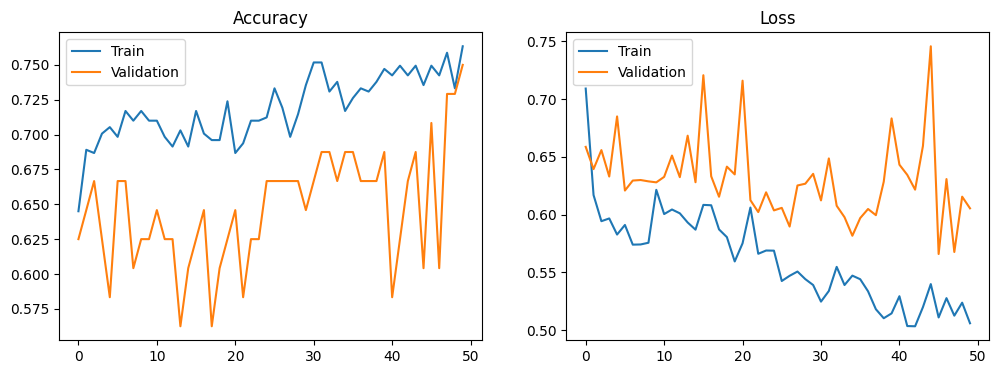

In [17]:
# Accuracy & Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()
plt.show()


In [18]:
# Clean test set (only 0 and 1)
valid_indices = np.where(np.isin(y_test, [0, 1]))[0]
X_test = X_test[valid_indices]
y_test = y_test[valid_indices]

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.5560 - loss: 0.8620
✅ Test Accuracy: 0.6052


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step


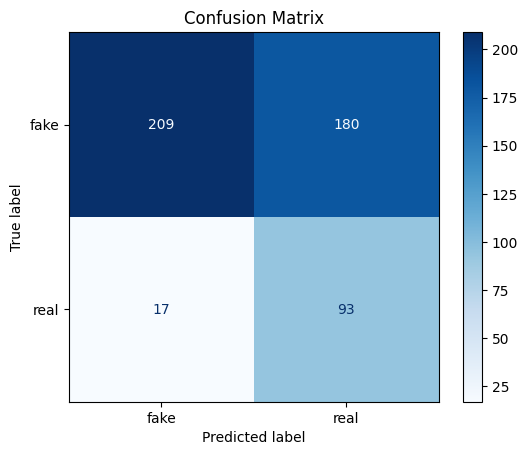

🧾 Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.54      0.68       389
        real       0.34      0.85      0.49       110

    accuracy                           0.61       499
   macro avg       0.63      0.69      0.58       499
weighted avg       0.80      0.61      0.64       499



In [19]:
# Confusion Matrix and Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

unique_classes = sorted(np.unique(np.concatenate((y_test, y_pred))))
class_labels_fixed = [class_labels[i] for i in unique_classes]

cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_fixed)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("🧾 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels_fixed))


Saving 5091.jpg to 5091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🧠 Prediction: real
✅ Confidence: 62.10%


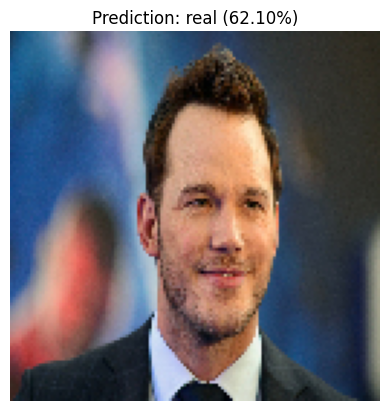

In [22]:
# Single Image Prediction
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class_idx = np.argmax(pred[0])
confidence = pred[0][predicted_class_idx]

class_labels_final = {0: 'fake', 1: 'real'}
predicted_class_name = class_labels_final[predicted_class_idx]

print(f"🧠 Prediction: {predicted_class_name}")
print(f"✅ Confidence: {confidence * 100:.2f}%")

plt.imshow(img)
plt.title(f"Prediction: {predicted_class_name} ({confidence * 100:.2f}%)")
plt.axis("off")
plt.show()
